In [68]:
import torch
import random
import numpy as np  # numpy
import torch.nn as nn  # nn objects
import torch.optim as optim  # nn optimizers
import matplotlib.pyplot as plt
%matplotlib notebook

## custom packages ##
from networkUtils import recurrentNet as rn
from taskUtils import generate as gen
from trainUtils import trainer as tn
from testUtils import test, plot

# Set device to gpu if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [69]:
# Hyperparameters
input_size = 5
num_classes = 2  # the number of units in the output layer
hidden_size = 10  # the number of units in the recurrent layer
batch_size = 1  # batch size = # of samples to average when computing gradient
num_layers = 1  # number of stacked RNN layers
eta = 0.001  # learning rate
epochs = 500  # epochs = # of full pases through dataset
num_networks = 5 # number of networks to average when calculating loss

In [70]:
# Loss function, optimizer, and schedule (for decaying learning rate)
criterion = nn.CrossEntropyLoss()  # loss function

In [71]:
def mean_loss(num_networks, condition, verbose=False):
    seqlen1, seqlen2, seqlen3 = condition[0], condition[1], condition[2]
    mean_loss = np.array([])
    seeds = []
    for i in range(num_networks):
        seed = rn.RecurrentXORNet(input_size, hidden_size, num_layers, num_classes, batch_size).to(device)
        optimizer = optim.Adam(seed.parameters(), eta)  # tells optimizer to adjust all parameter weights with steps based on eta
        sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=False) # lowers lr if the loss global min doesn't decrease for 5 epochs
        dataset, targets, sequence_length = gen.generate_dataset(False, input_size, seqlen1, seqlen2, seqlen3)
        loss = tn.train_network(seed, dataset, targets, sequence_length, input_size, batch_size, epochs, optimizer, criterion, sheduler, verbose)
        if i == 0:
            mean_loss = loss
        else:
            mean_loss = mean_loss + loss
        seeds.append(seed)
    mean_loss = mean_loss/num_networks
    return mean_loss, seeds

In [72]:
smallest = [1, 2, 3] # smallest
bigger = [10, 15, 20] # bigger
even_bigger = [25, 50, 100] # even bigger
largest = [50, 100, 200] # largest

In [73]:
mean_loss_1,_ = mean_loss(num_networks, smallest)
mean_loss_2,_ = mean_loss(num_networks, bigger)
mean_loss_3,_ = mean_loss(num_networks, even_bigger)
mean_loss_4,_ = mean_loss(num_networks, largest)

<IPython.core.display.Javascript object>


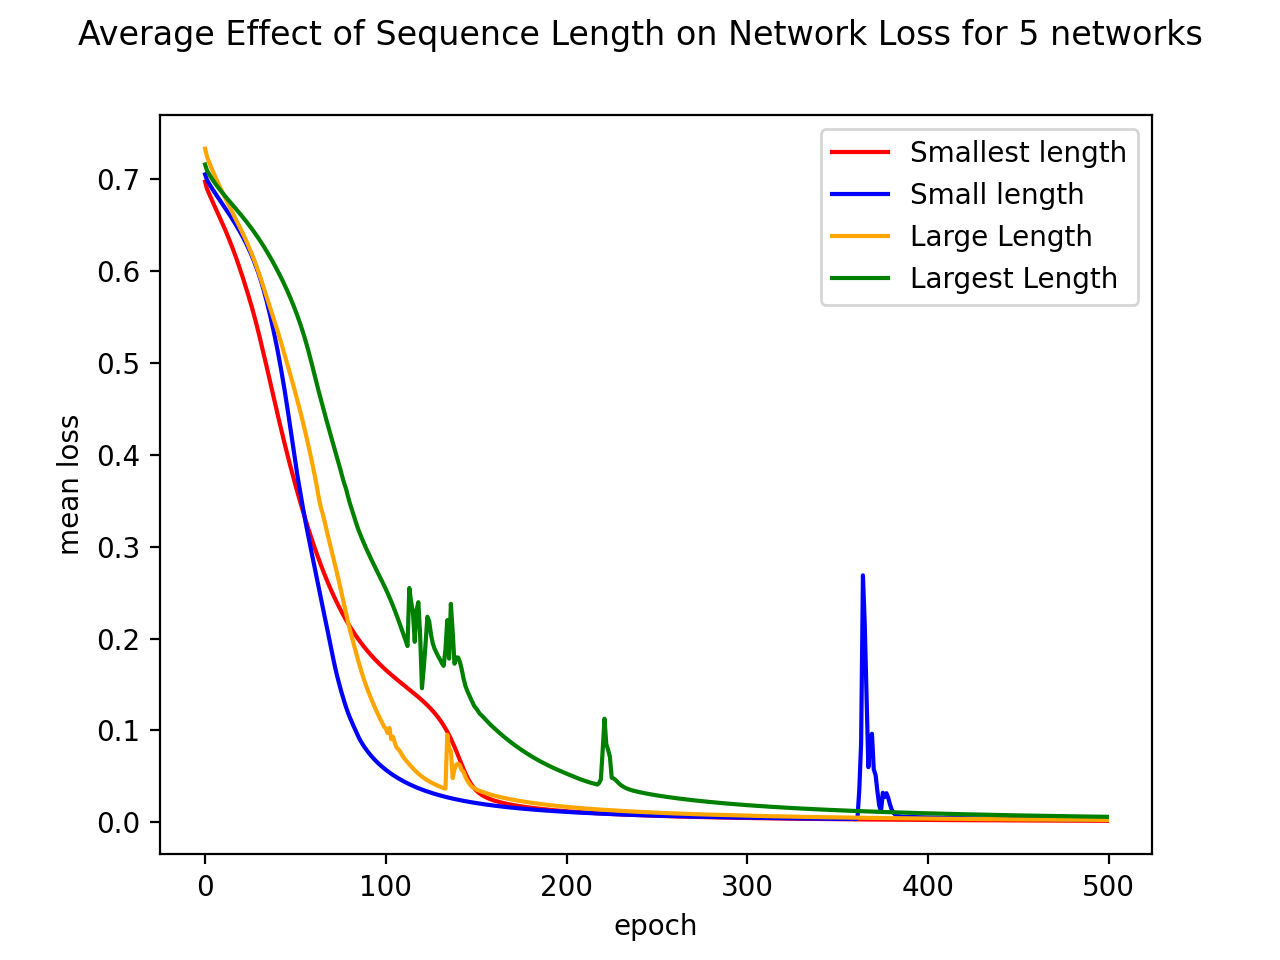

In [74]:
# plot losses
plot.plot_four_losses("Average Effect of Sequence Length on Network Loss for 5 networks", 
                 mean_loss_1, mean_loss_2, mean_loss_3, mean_loss_4)
plt.legend(["Smallest length", "Small length", "Large Length", "Largest Length"])
plt.show()